**19_Bump_NPF_rewet___see_ex: 08_09_10**

In [1]:
import os ; import pathlib as pl ; import flopy ; import matplotlib.pyplot as plt ; import numpy as np; from pathlib import Path  
from flopy.plot.styles import styles ; import shapefile as shp ; import matplotlib as mpl ; import pandas as pd  
from modflow_devtools.misc import get_env, timed ; write=get_env("WRITE", True);run=get_env("RUN", True)

In [2]:
sim_ws    = Path("./19_bump")                       ; sim_ws.mkdir(exist_ok=True) ; sim_name = "ex-gwf-bump"   
exe_name  = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' ; workspace = figs_path = sim_ws ; gwf_name = sim_name ; output_folder = sim_ws   
path = 'E:\\15_REPOS\\00_BETAMI\\bin\\data_modflow6-examples\\ex-gwf-bump'  ; fpath=os.path.join(path,"bottom.txt")      

In [3]:
length_units = "meters" ; time_units = "days"       ; nouter = 500 ;ninner = 500 ;hclose = 0.000000001 ; rclose = 0.000001 
parameters={"ex-gwf-bump-p01a":{"newton" : "newton"},
            "ex-gwf-bump-p01b":{"rewet"  : True     , "wetfct"     :1.0   ,"iwetit":1  ,"ihdwet":0  ,"wetdry":2.0},
            "ex-gwf-bump-p01c":{"newton" : "newton" , "cylindrical":True}}
nper = 1 ;nlay = 1 ;nrow = 51 ;ncol = 51 ;xlen = 100   ;ylen = 100 ;top = 25      ;k11 = 1 ;H1 = 7.5 ;H2 = 2.5 
tdis_ds = ((1.0, 1, 1.0),) ; delr = xlen / float(ncol) ;delc = ylen / float(nrow) ;shape3d = (nlay, nrow, ncol)   #;extents = (0, xlen, 0, ylen) 
botm = np.loadtxt(fpath).reshape(shape3d)              ;cylinder = botm.copy()    ;cylinder[cylinder < 7.5] = 0.0 ;cylinder[cylinder >= 7.5] = 20.0
chd_spd = [[0, i, 0, H1] for i in range(nrow)]         ;chd_spd += [[0, i, ncol - 1, H2] for i in range(nrow)]

In [4]:
def build_models(name,newton=False,rewet=False,cylindrical=False,wetfct=None,iwetit=None,ihdwet=None,wetdry=None,):
    if newton:      linear_acceleration = "bicgstab"  ; newtonoptions = "newton under_relaxation"
    else:           linear_acceleration = "cg"        ; newtonoptions = None
    if cylindrical: bot = cylinder   
    else:           bot = botm
    if rewet:       rewet_record = ["wetfct", wetfct, "iwetit", iwetit, "ihdwet", ihdwet]
    else:           rewet_record = None
    head_filerecord = f"{sim_name}.hds"  ; budget_filerecord=f"{sim_name}.cbc"
    
    sim_ws = os.path.join  (workspace, name)
    sim = flopy.mf6.MFSimulation     (sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis    (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms     (sim ,print_option="ALL"  ,linear_acceleration=linear_acceleration ,outer_maximum=nouter ,outer_dvclose=hclose ,
                                  inner_maximum=ninner ,inner_dvclose=hclose ,rcloserecord=rclose)
    gwf=flopy.mf6.ModflowGwf (sim ,modelname=sim_name  ,newtonoptions=newtonoptions ,save_flows=True)
    flopy.mf6.ModflowGwfdis  (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=bot)
    flopy.mf6.ModflowGwfnpf  (gwf ,rewet_record=rewet_record ,icelltype=1 ,k=k11 ,wetdry=wetdry ,save_specific_discharge=True)
    flopy.mf6.ModflowGwfic   (gwf ,strt=H1)
    flopy.mf6.ModflowGwfchd  (gwf ,stress_period_data=chd_spd)
    flopy.mf6.ModflowGwfoc   (gwf ,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,saverecord=[("HEAD","ALL"),("BUDGET","ALL")])
    return sim
def write_models(sim, silent=True):   sim.write_simulation(silent=silent)  
@timed
def run_models(sim, silent=True):     success, buff = sim.run_simulation(silent=silent)  ; assert success, buff
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]               ;  params = parameters[key].copy()  ; sim = build_models(key, **params)
    if write:   write_models(sim, silent=silent)
    if run:       run_models(sim, silent=silent)
scenario(0); scenario(1); scenario(2)

run_models took 321.99 ms
run_models took 195.46 ms
run_models took 143.51 ms


Newton-Raphson formulation to simulate dry cells. ____ Rewet: False


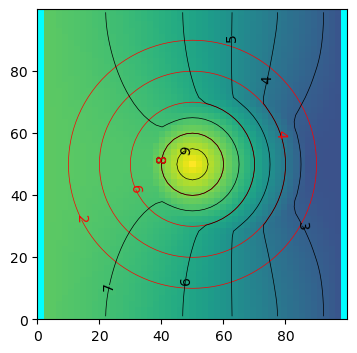

head__vhmin,vhmax 2 9 botom__vbmin,vbmax 0 9


In [5]:
sim_ws1 = Path("./19_bump/ex-gwf-bump-p01a")  ; print('Newton-Raphson formulation to simulate dry cells. ____ Rewet: False')
sim  = flopy.mf6.MFSimulation.load(sim_ws = sim_ws1 ,exe_name = exe_name ,verbosity_level = 0)           ; gwf = sim.get_model(sim_name)  
hobj = gwf.output.head()  ;  head = hobj.get_data(totim=1.0)             ;th = pd.DataFrame(head[0,:,:])  ; th.to_csv(sim_ws/'02a_head.csv')    
bot  = gwf.dis.botm.array                                                ;tb = pd.DataFrame(bot [0,:,:])  ; tb.to_csv(sim_ws/'02b_boton.csv')   
fig = plt.figure(figsize=(4, 50)) ; mm = flopy.plot.PlotMapView(gwf, extent = gwf.modelgrid.extent)
bh = np.arange(0, th.max().max(),1)                                      ;bb = np.arange(tb.min().min()+2, tb.max().max(),2)    

cv1 = mm.plot_array    ( head    , vmin       = tb.min().min()       , vmax=tb.max().max() )
cv2 = mm.contour_array ( head    , levels     = bh  ,colors='black'  , linewidths=0.5,linestyles="-"  ,zorder=10)
cv3 = mm.contour_array ( bot     , linewidths = 0.5 , linestyles="-" , levels = bb ,colors='red')  
plt.clabel(cv2, fmt="%1.0f",zorder=10) ; plt.clabel(cv3, fmt="%1.0f" , zorder=10) ; mm.plot_bc("CHD", color="cyan")     ; plt.show()
vhmin=th.min().min() ;vhmax=th.max().max()     ;vbmin=tb.min().min() ; vbmax=tb.max().max()       
print('head__vhmin,vhmax',int(vhmin),int(vhmax),'botom__vbmin,vbmax' , int(vbmin),int(vbmax))

Newton-Raphson formulation to simulate dry cells. ____ Rewet: False


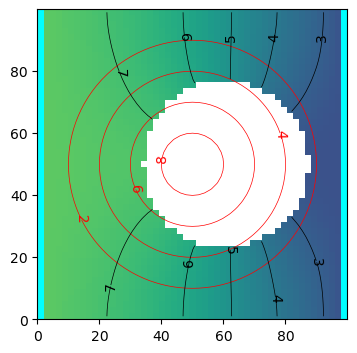

head__vhmin,vhmax -1000000000000000019884624838656 7 botom__vbmin,vbmax 0 9


In [6]:
sim_ws1 = Path("./19_bump/ex-gwf-bump-p01b")  ; print('Newton-Raphson formulation to simulate dry cells. ____ Rewet: False')
sim  = flopy.mf6.MFSimulation.load(sim_ws = sim_ws1 ,exe_name = exe_name ,verbosity_level = 0)           ; gwf = sim.get_model(sim_name)  
hobj = gwf.output.head()  ;  head = hobj.get_data(totim=1.0)             ;th = pd.DataFrame(head[0,:,:])  ; th.to_csv(sim_ws/'02a_head.csv')    
bot  = gwf.dis.botm.array                                                ;tb = pd.DataFrame(bot [0,:,:])  ; tb.to_csv(sim_ws/'02b_boton.csv')   
fig = plt.figure(figsize=(4, 50)) ; mm = flopy.plot.PlotMapView(gwf, extent = gwf.modelgrid.extent)
bh = np.arange(0, th.max().max(),1)                                      ;bb = np.arange(tb.min().min()+2, tb.max().max(),2)    

cv1 = mm.plot_array    ( head    , vmin       = tb.min().min()       , vmax=tb.max().max() )
cv2 = mm.contour_array ( head    , levels     = bh  ,colors='black'  , linewidths=0.5,linestyles="-"  ,zorder=10)
cv3 = mm.contour_array ( bot     , linewidths = 0.5 , linestyles="-" , levels = bb ,colors='red')  
plt.clabel(cv2, fmt="%1.0f",zorder=10) ; plt.clabel(cv3, fmt="%1.0f" , zorder=10) ; mm.plot_bc("CHD", color="cyan")     ; plt.show()
vhmin=th.min().min() ;vhmax=th.max().max()     ;vbmin=tb.min().min() ; vbmax=tb.max().max()       
print('head__vhmin,vhmax',int(vhmin),int(vhmax),'botom__vbmin,vbmax' , int(vbmin),int(vbmax))

Newton-Raphson formulation to simulate dry cells. ____ Rewet: False


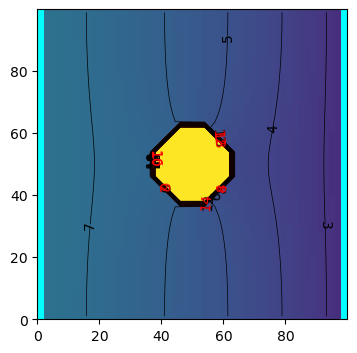

head__vhmin,vhmax 2 19 botom__vbmin,vbmax 0 20


In [7]:
sim_ws1 = Path("./19_bump/ex-gwf-bump-p01c")  ; print('Newton-Raphson formulation to simulate dry cells. ____ Rewet: False')
sim  = flopy.mf6.MFSimulation.load(sim_ws = sim_ws1 ,exe_name = exe_name ,verbosity_level = 0)           ; gwf = sim.get_model(sim_name)  
hobj = gwf.output.head()  ;  head = hobj.get_data(totim=1.0)             ;th = pd.DataFrame(head[0,:,:])  ; th.to_csv(sim_ws/'02a_head.csv')    
bot  = gwf.dis.botm.array                                                ;tb = pd.DataFrame(bot [0,:,:])  ; tb.to_csv(sim_ws/'02b_boton.csv')   
fig = plt.figure(figsize=(4, 50)) ; mm = flopy.plot.PlotMapView(gwf, extent = gwf.modelgrid.extent)
bh = np.arange(0, th.max().max(),1)                                      ;bb = np.arange(tb.min().min()+2, tb.max().max(),2)    

cv1 = mm.plot_array    ( head    , vmin       = tb.min().min()       , vmax=tb.max().max() )
cv2 = mm.contour_array ( head    , levels     = bh  ,colors='black'  , linewidths=0.5,linestyles="-"  ,zorder=10)
cv3 = mm.contour_array ( bot     , linewidths = 0.5 , linestyles="-" , levels = bb ,colors='red')  
plt.clabel(cv2, fmt="%1.0f",zorder=10) ; plt.clabel(cv3, fmt="%1.0f" , zorder=10) ; mm.plot_bc("CHD", color="cyan")     ; plt.show()
vhmin=th.min().min() ;vhmax=th.max().max()     ;vbmin=tb.min().min() ; vbmax=tb.max().max()       
print('head__vhmin,vhmax',int(vhmin),int(vhmax),'botom__vbmin,vbmax' , int(vbmin),int(vbmax))